In [15]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import corner
import json

import pytensor
from pytensor import tensor as pt
from pytensor.graph.basic import Apply
from pytensor.graph import Apply, Op

import jax
from jax import grad, jit, vmap, value_and_grad, random
import jax.numpy as jnp

import pyhf
pyhf.set_backend('numpy')

import pymc as pm
import arviz as az

from pyhf_pymc import prepare_inference
from pyhf_pymc import infer
from pyhf_pymc import make_op
from pyhf_pymc import plotting

%load_ext autoreload
%autoreload 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
blue = '#1F449C'
pink = '#E57A77'

In [17]:
model = pyhf.Model(
        {'channels': [{'name': 'singlechannel',
        'samples': [
        {'name': 'signal',
        'data': [10, 20, 10],
        'modifiers': [
            {'name': 'mu', 'type': 'normfactor', 'data': None},
            {'name': 'mu2', 'type': 'normfactor', 'data': None}]},
        {'name': 'background',
        'data': [120, 110, 100],
        'modifiers': [
            # Normalisation Uncertainty / Normal
            {'name': 'normSys', "type": "normsys", "data": {"hi": 0.95, "lo": 1.05}},
            # Staterror / Normal
            {"name": "my_staterror","type": "staterror","data": [10.1, 1.01, 0.101],},
            # Uncorrelated / Poisson
            {'name': 'uncorr_bkg', 'type': 'shapesys','data': [40, 51, 62]}
            ]}]}]
            }
        )

data = [110, 105, 100]
auxdata = model.expected_auxdata(model.config.suggested_init())

unconstr_priors = {
    'mu': {'type': 'HalfNormal_Unconstrained', 'sigma': [0.4]},
    'mu2': {'type': 'Gamma_Unconstrained', 'alpha': [5.], 'beta': [1.]}
}

In [12]:
model.config.poi_name

'mu'

In [13]:
priorDict_conjugate = prepare_inference.build_priorDict_conjugate(model, unconstr_priors)
len(priorDict_conjugate.keys())

5

In [22]:
pyhf.set_backend('numpy')
with infer.model_conjugate(model, unconstr_priors, data):
    step = pm.Metropolis()
    post_data = pm.sample(draws=1_00, chains=1_0, step=step)
    post_pred = pm.sample_posterior_predictive(post_data)
    prior_pred = pm.sample_prior_predictive(1_00)

Only 100 samples in chain.
Multiprocess sampling (10 chains in 4 jobs)
CompoundStep
>Metropolis: [mu]
>Metropolis: [mu2]
>Metropolis: [normSys]
>Metropolis: [uncorr_bkg]
>Metropolis: [my_staterror]


Sampling 10 chains for 1_000 tune and 100 draw iterations (10_000 + 1_000 draws total) took 5 seconds.
Sampling: [Expected_Data]


Sampling: [Expected_Data, mu, mu2, my_staterror, normSys, uncorr_bkg]


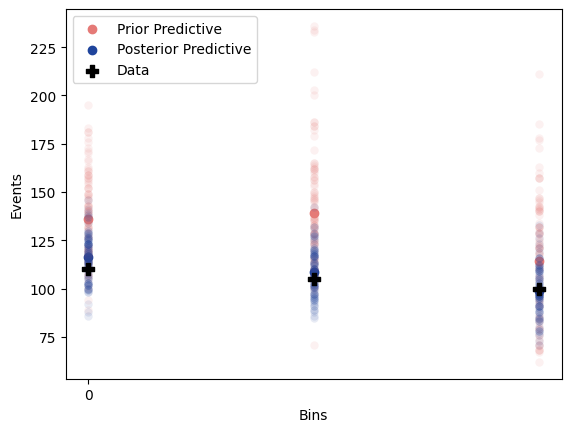

In [23]:
plotting.prior_posterior_predictives(model=model, data=data, post_pred=post_pred, prior_pred=prior_pred, bin_steps=5)